# Demo of PLS regression and EMSC preprocessing
This Jupyter Notebook gives an overview of how a typical chemometric regression workflow may be performed with `chemometrics`. Here, extended multiplicative signal correction (EMSC) is used to remove known interfering variations. In this example, the EMSC is integrated into a scikit-learn `Pipeline` such that the treated spectra can immediately be used for concentration predictions.

First, the search path is adjusted to include the local chemometric library and the other relevant packages are loaded. Numpy is used for matrix handling, matplotlib provides plotting functionality. From sklearn some helper functions are included which will be used later on.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import chemometrics as cm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

## Generating artificial data

For this example, synthetic spectral data is used. The synthetic spectra must be rather complex to demonstrate the benefits of the EMSC preprocessing. EMSC is especially powerful if spectra are corrupted by known background signals which are orthogonal to the target signal but display a similar bandwidth.

We will use an artificial background composed of four contributions. 1) and 2): Two correlated background chemicals with sharp features which mask the target component spectra. 3) One slower varying broadband contaminating signal is added for additional complexity. 4) Furthermore, we also include Gaussian noise in the background. To generate said signals, we rely on support functions which chemometrics provides. `generate_background` uses a Gaussian process to generate a slowly varying background. `generate_spectra` distributes Gaussian peaks with random width and height over the baseline.

Below, individual background contributions 1) to 3) are generated and plotted for illustration purposes.

Text(0, 0.5, 'Predictor signal')

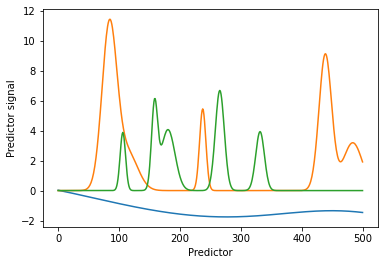

In [2]:
n_wl = 500
n_band = 5
bandwidth = 3
n_samples = 50
noise = 0.2
target_component_height = 0.1

np.random.seed(1)
bg1 = cm.generate_background(n_wl)
bg2 = cm.generate_spectra(n_wl, n_band, bandwidth)
bg3 = cm.generate_spectra(n_wl, n_band, bandwidth)

plt.plot(bg1)
plt.plot(bg2)
plt.plot(bg3)

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

The individual contributions 1) to 3) are combined and the random noise 4) added to receive an artificial background of chemical and baseline contributions.

Text(0, 0.5, 'Predictor signal')

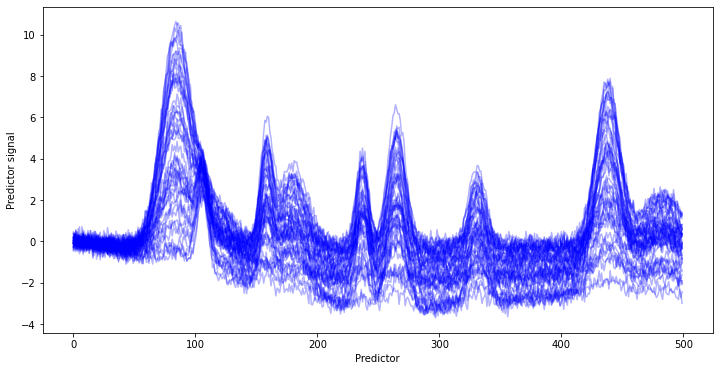

In [3]:
plt.figure(figsize=[12, 6])
sample = np.arange(n_samples)[:,None]
background_wo_noise = bg1.T * np.random.uniform(size=[n_samples,1]) * 2 + sample/n_samples*bg2.T + (1-sample/n_samples) * bg3.T
background = background_wo_noise + np.random.normal(scale=noise, size=[n_samples, n_wl])

lines = plt.plot(background.T, 'blue', alpha=0.3)

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

The target signal is again generated using the helper function `generate_spectra` as well as a randomly distributed target value `y` (e.g. a concentration). In this case, we do not look at the pure spectrum (for fun). Instead, we add the target signal to the background and plot the obtained spectra with `plot_colored_series` colored according to the value of `y`.

Text(0, 0.5, 'Predictor signal')

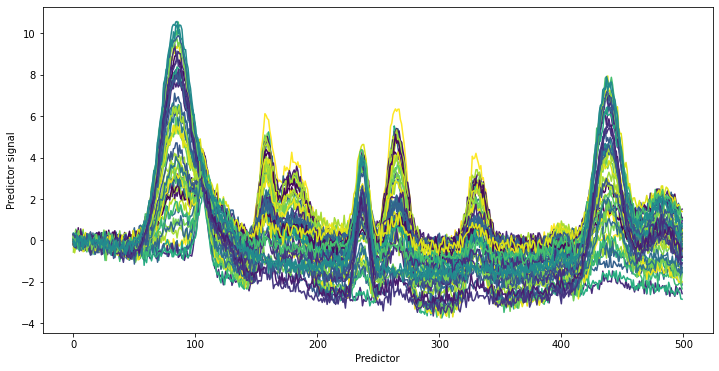

In [4]:
y = np.random.uniform(high=target_component_height, size = [n_samples, 1])
pure_spec = cm.generate_spectra(n_wl, n_band, bandwidth)
spectra = background_wo_noise + y * pure_spec + np.random.normal(scale=noise, size=[n_samples, n_wl])

plt.figure(figsize=[12, 6])
lines = cm.plot_colored_series(spectra.T, reference=y[:,0])

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

It is diffcult to notice any relevant changes to the spectra even when providing coloring according to the `y` values. If looking at the predictors around 400, a new peak is visible in the data which was not present in the background spectra. Otherwise, no other additional peaks are apparent. This is also the intention of this example. If looking at the parameter for the artificial dataset, the standard deviation `noise` of the measurement noise (component 4) was set to 0.2. The background chemical signals vary between 0 and 1. The signal of the target component has a maximum height 10 times smaller than the background. It is furthermore not much larger than the Gaussian measurement noise. The example is thus very fitting for a challenging real-world applications.

## PLS model calibration without pretreamten

It will now be interesting to see how a PLS model copes with this challenging data set. Here, a cross-validation is performed with the scikit-learn function `cross_val_score` for 1 to 10 latent variables. By default, `cross_val_score` performs a five-fold venitian-blind cross-validation and returns a metric for each subset. As metric, the coefficient of determination is used. 
$$S = 1 - \frac{RSS}{TSS},$$

where $S$ is the score, $RSS$ is the residual sum of squares and $TSS$ is the total sum of squares. The overall score $Q^2$ per latent variable is computed by averaging over the five subset cross-validation scores, i.e.
$$ Q^2 = \frac{1}{n}\sum_{CV} S_{CV}.$$
Additionally, also the coefficient of determination of the PLS model on the whole data set $R^2$ is also calculated as a reference. The $R^2$ and $Q^2$ were plotted to provide an overview of the model performance with an increasing number of latent variables.

(-0.5, 1.0)

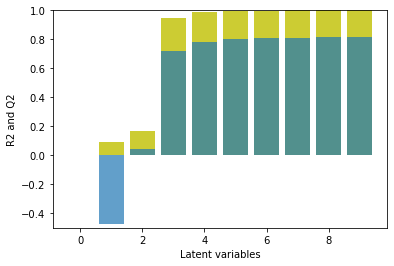

In [5]:
def eval_pls(spectra, y):
    max_lv = 10

    scores_cv = np.zeros(max_lv)
    scores = np.zeros(max_lv)

    for i in range(1, max_lv):
        pls = cm.PLSRegression(n_components=i)
        scores_cv[i] = np.mean(cross_val_score(pls, spectra, y))
        scores[i] = pls.fit(spectra, y).score(spectra, y)

    plt.bar(np.arange(max_lv), scores, color=[0.8, 0.8, 0.2], alpha=1)    
    plt.bar(np.arange(max_lv), scores_cv, alpha=0.7)
    
    plt.xlabel('Latent variables')
    plt.ylabel('R2 and Q2')

eval_pls(spectra, y)
plt.ylim([-0.5, 1])

Quite distinctively, the first two latent variables do not contribute to the prediction of the model. Also the PLS model is dominated by variations which are not useful for the target variable prediction. Only the following latent variables help to improve the prediction during cross-validation. The cross-validation scores reach 0.8 with 5 latent variables and where the scores level out. This is different to the behavior of non-artificial data, where typically a decrease of the model performance during cross-validation is observed after a maximum. 

In the following, we opt for rather a conservative choice of latent variables. The third latent variable contributes most to the overall model performance. All subsequent latent variables do not improve the model performance similarly. Since the benefits of added latent variables is limited, it seems more reasonable to keep it at a minimum number of latent variables. The PLS model is calibrated on the whole data set. To inspect the overall model performance, we may take a look at the observed versus predicted plot. The VIPs are available as part of the chemometric `PLSRegression` object. Based on the VIPs, one can see which predictors are important for the model. 

R2: 0.9474881690840495




Text(0, 0.5, 'VIP')

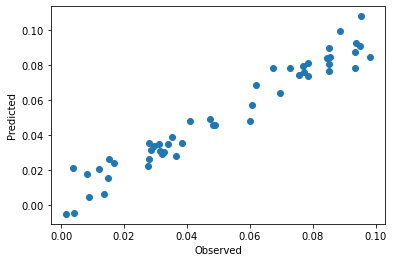

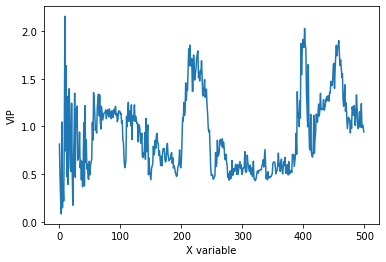

In [6]:
pls = cm.PLSRegression(n_components=3).fit(spectra, y)

print(f'R2: {pls.score(spectra, y)}\n\n')

plt.scatter(y, pls.predict(spectra)[:,0])
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.figure()
plt.plot(pls.vip_)
plt.xlabel('X variable')
plt.ylabel('VIP')

The R2 value with three latent variables is >0.9.  The predictions during calibration are distinctively better than the performance during cross-validation. This indicates an overfitting of the model even with only three latent variables. Also based on the behavior of the VIPs, it becomes clear that the model is corrupted by noise. Based on the used data set (and also what we would e.g. expect for spectroscopic data), we would expect a smooth trend with continuous variation. The VIPs however have a rather jittery appearance

In summary, we could see, that the spectra are strongly influenced by the background, the model performance during cross-validation is mediocrate and the VIPs are corrupted by noise. A degree of model overfitting seems likely. A pretreatment may help to improve the prediction and reduce the required number of latent variables. 

## Using an EMSC filter for background removal
The `Emsc` object in chemometrics provides the functionality of removing slowely varying background signals. Furthermore, the object also provides functionality for orthognalizing spectra with respect to a background signal. To understand this functionality, a quick overview of the inner workings of the `Emsc` is given.

In principle, an EMSC works by splitting the provided spectrum $A$ into multiple contributing vectors. For a standard EMSC (without additional orthogonalization), the contributing vectors are:
1) average spectra $\bar D$,

2) polynomial contributions (e.g. constant, linear, etc.) $P$,

3) residuals $R$.


All contributions are linearly scaled by a factor $C$ to minimize the residuals to the target spectrum. 
$$ \min_C || C * [\bar D, P]^T - D^T||_2^2$$

The somewhat surprising approach of the EMSC is now to actually remove all variation by the polynomial contributions and just retain the scaled average spectra *and* the residuals. The approach is easily extended to remove additional components by just adding additional vectors to the linear fit. The number of components provided to the EMSC has to be limited to prevent an amplification of noise.

In practice, information on the interferring variations in the spectra may be available by e.g.:
- blank measuremements
- blank experiments (e.g. blank chromatography runs) resulting in numerous spectra
- spectra from pure interferring components
It may be useful to include measurements over an extended time to capture the drift of the instrument.


In our case, we will use the 50 background spectra to provide an insight into the interferring chemical components and background shift. We will also use a Whittaker filter to remove noise from the spectra (for details on the Whittaker filter, refer to the corresponding documentation and [this example](https://github.com/maruedt/chemometrics/blob/master/examples/whittaker.ipynb)). First, it may be worth to just get a general impression of the trends in the dataset. The function `plot_svd` plots the singular vectors and singular values of a dataset. It is comparable to a PCA except that the data is not mean centered and the scale of the variation is captured by the singular values (not in the scores as for the PCA). The functionalities of `Whittaker` and `plot_svd` are simply chained.

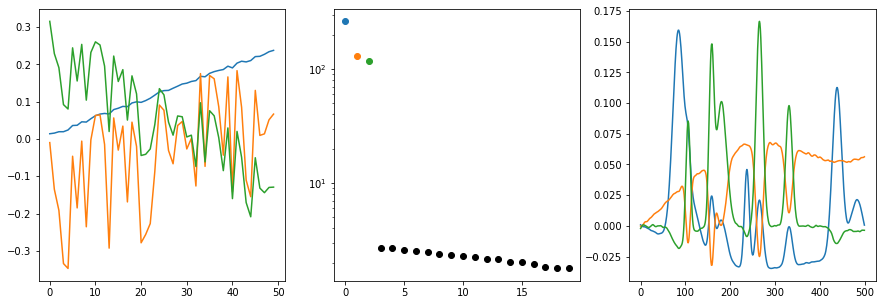

In [7]:
cm.plot_svd(cm.Whittaker().fit_transform(background), n_comp=3)

Given how the background was generated, we do not see any big surprises. The first three singular vectors are necessary to capture the fast majority of background variation. The rest is noise and potentially numerical artifacts. Based on the right singular vectors, we can already see that some noise is captured by the singular vector 2 (orange) and 3 (green). This is also expected and quite normal. Based on these observations, three components will also be the optimal number of components for the background removal of the EMSC.

In the following, a first scikit-learn `Pipeline` is used to smooth and extract the right singular vectors from the background. A second pipeline is used for the main routine consisting of smoothing the spectra and adding a EMSC filter. Finally, the resulting data is plotted with `plot_colored_series` to show the quality of preprocessed spectra.

Text(0, 0.5, 'Predictor signal')

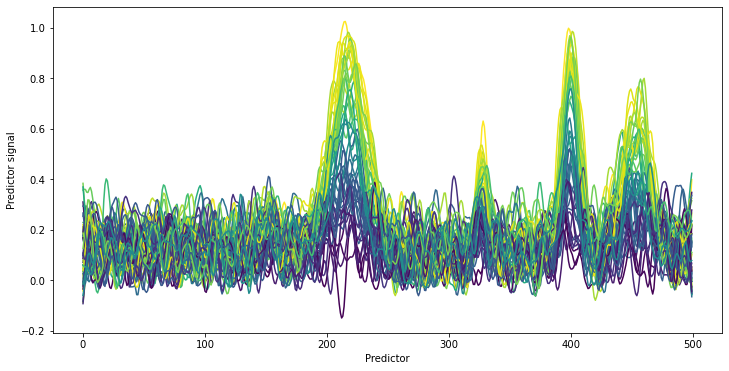

In [8]:
# extract background
bg_pipeline = make_pipeline(cm.Whittaker(), TruncatedSVD(n_components=3))
bg_pipeline = bg_pipeline.fit(background)
right_singular_vectors = bg_pipeline[-1].components_.T

# construct pipeline and treat spectra 
pipeline = make_pipeline(cm.Whittaker(), cm.Emsc(background=right_singular_vectors))
spectra_pretreated = pipeline.fit_transform(spectra)


plt.figure(figsize=[12, 6])
lines = cm.plot_colored_series(spectra_pretreated.T, reference=y[:,0])
plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

After pretreating the spectra, no obvious baseline shifts are visible anymore. Clearly, the four peaks of the actual target component remain. The spectra show the typical sorting by concentration which is expected for typical quantitative chemometric applications. This is especially impressive as only the peak at predictor 400 was discernable by eye in the original spectra.

Since we have now seen that the baseline can be efficiently removed by the EMSC, we will now test how the pretreatment affects the model quality of the PLS model. Similar to above, the Q2 and R2 will be compared over the different latent variables.

(0.0, 1.0)

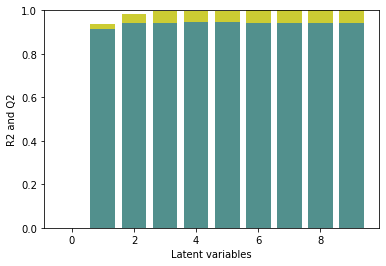

In [9]:
eval_pls(spectra_pretreated, y)
plt.ylim([0,1])

The R2/Q2 plot shows that the first two latent varibales improve the model performance. The additional latent variables lead to an improvement of the R2 while the Q2 remains almost constant, i.e. the model is overfitted with >2 componentes. Comparing the results to the model performance without pretreatment, we can see, that the R2/Q2 are increased and the number of latent variables is decreased. We would thus expect a better model performance for a prediction data set and a more robust model.

We may still inspect the observed versus predicted plot and the VIPs for the final model.

Text(0, 0.5, 'VIP')

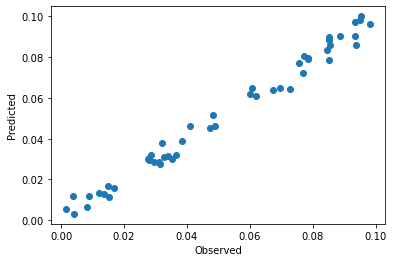

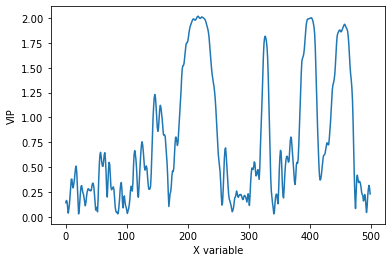

In [10]:
pls = cm.PLSRegression(n_components=2).fit(spectra_pretreated, y)

plt.scatter(y, pls.predict(spectra_pretreated)[:,0])
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.figure()
plt.plot(pls.vip_)
plt.xlabel('X variable')
plt.ylabel('VIP')

As expected, the data is closer to the parity line in the observed versus predicted plot than without pretreatment. VIPs are smoother which also indicate less overfitting of the model after pretreatment.

Overall, the EMSC helped to remove the baseline behavior of the generated data leading to an easier visual interpretation. The calibrated model on the pretreated data shows a better model performance with less latent variables and less overfitting. A pretreatment with an EMSC is especially interesting when known interferences need to be removed. Next to better model performance, the pretreated data is typically also easier to interpet.